<h1>Final Assignment(21029971)</h1>
<p>Violent Crimes in Lockdown Britain. The data here is taken from multiple sources provided by UK police related to street level crime. Altogther there many categories of crime that is recorded during period including domestic and violent crimes. Our task is to analyze the crimes during the lock what was the trend of violent crimes.<p/>

In [2]:
# Adding all import functions that are going to be used in our assignment
import numpy as np
import pandas as pd
import pyspark
import collections
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date, countDistinct, min as min_value, max as max_value

import statsmodels.api as sm

In [3]:
#Checking for the spark context: Showing spark version and app name
spark = SparkSession\
.builder\
.appName("Final Assignment")\
.getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Final Assignment>

<h3>Loading Data from source</h3>
<p>The next steps will related to loading data from all crimes and location file, showing their schema and structure</p>

In [4]:
%%time
url = "http://unn-izje1.newnumyspace.co.uk/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)

df = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)

CPU times: user 208 ms, sys: 70.7 ms, total: 278 ms
Wall time: 15min 43s


In [6]:
# Defing the schema for crimes data
schema = StructType([
    StructField("Crime ID", StringType(), True),
    StructField("Timestamp", StringType(), True),
    StructField("Reported by", StringType(), True),
    StructField("Falls within", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("LSOA code", StringType(), True),
    StructField("LSOA name", StringType(), True),
    StructField("Crime type", StringType(), True),
    StructField("Last outcome category", StringType(), True),
    StructField("Context", StringType(), True)]
)

<h3>Crimes Data</h3>
Loading all crimes data by setting schema as defined above.

In [7]:
df_crimes = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema=schema)

In [8]:
#Printing schema of all crimes data
df_crimes.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [9]:
#Attributes of allcrimes
df_crimes.columns

['Crime ID',
 'Timestamp',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA code',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context']

Displaying first 5 rows

In [10]:
df_crimes.show(5)

+--------+---------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|Timestamp|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+---------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|  2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|  2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|  2010-12|Avon and Somerset...|Avon and Somerset...|-2.51192

<h3>Location File</h3>
<p>Loading data of location files, printing its schema and columns.</p>

In [11]:
%%time
location_url = "http://unn-izje1.newnumyspace.co.uk/LSOA_pop_v2.csv"
spark.sparkContext.addFile(location_url)

location_df = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

CPU times: user 0 ns, sys: 7.58 ms, total: 7.58 ms
Wall time: 4.82 s


In [12]:
#Printing schema
location_df.printSchema()

root
 |-- date: integer (nullable = true)
 |-- geography: string (nullable = true)
 |-- geography code: string (nullable = true)
 |-- Rural Urban: string (nullable = true)
 |-- Variable: All usual residents; measures: Value: integer (nullable = true)
 |-- Variable: Males; measures: Value: integer (nullable = true)
 |-- Variable: Females; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a household; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a communal establishment; measures: Value: integer (nullable = true)
 |-- Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value: integer (nullable = true)
 |-- Variable: Area (Hectares); measures: Value: double (nullable = true)
 |-- Variable: Density (number of persons per hectare); measures: Value: double (nullable = true)



In [13]:
location_df.columns

['date',
 'geography',
 'geography code',
 'Rural Urban',
 'Variable: All usual residents; measures: Value',
 'Variable: Males; measures: Value',
 'Variable: Females; measures: Value',
 'Variable: Lives in a household; measures: Value',
 'Variable: Lives in a communal establishment; measures: Value',
 'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value',
 'Variable: Area (Hectares); measures: Value',
 'Variable: Density (number of persons per hectare); measures: Value']

<h3>Dropping attributes</h3>
Let's first drop the attributes that are going to be of no use in our analysis

In [14]:
df_crime_updated = df_crimes.drop("Crime ID", "Falls within", "Last outcome category", "Context")
df_crime_updated.show(5)

+---------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|Timestamp|         Reported by|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|
+---------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|  2010-12|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|
|  2010-12|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|
|  2010-12|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social behav...|
|  2010-12|Avon and Somerset...|-2.511571|51.414895|On or near Orchar...|E01014399|Bath and North Ea...|Anti-social behav...|
|  2010-12|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social be

<h3>Joining Datasets</h3>
<p>Now joining datasets of crimes data and location data. Saving it in a dataframe and its going to be used further in our analysis.</p>

In [15]:
#Joining tables on LSOA code attribute in crimes and geography code attribute in location
df_joined_datasets = df_crime_updated.join(location_df,df_crime_updated["LSOA code"] == location_df["geography code"],how='inner')

In [14]:
df_joined_datasets.take(5)

[Row(Timestamp='2010-12', Reported by='Avon and Somerset Constabulary', Longitude=-0.8056, Latitude=51.819143, Location='On or near Norfolk Terrace', LSOA code='E01017662', LSOA name='Aylesbury Vale 015C', Crime type='Other crime', date=2011, geography='Aylesbury Vale 015C', geography code='E01017662', Rural Urban='Total', Variable: All usual residents; measures: Value=1308, Variable: Males; measures: Value=631, Variable: Females; measures: Value=677, Variable: Lives in a household; measures: Value=1296, Variable: Lives in a communal establishment; measures: Value=12, Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value=13, Variable: Area (Hectares); measures: Value=29.95, Variable: Density (number of persons per hectare); measures: Value=43.7),
 Row(Timestamp='2010-12', Reported by='Avon and Somerset Constabulary', Longitude=-2.494366, Latitude=51.418169, Location='On or near Keynsham Road', LSOA code='E01014399', LSOA name='Bath a

<h3>What crime categories does the Police Data Use?</h3>
First for the police categories, we are going to find total crime types, then the names of the categories and there overall count for each crime type that has been recorded.

In [16]:
%%time
df_crime_updated.agg(countDistinct(col("Crime type")).alias("count")).show()

+-----+
|count|
+-----+
|   16|
+-----+

CPU times: user 42.1 ms, sys: 11.7 ms, total: 53.8 ms
Wall time: 2min 29s


<h3>Distinct Crime Categories</h3>

In [17]:
#Getting distinct crime types
[x["Crime type"] for x in df_crime_updated.select('Crime type').distinct().collect()]

['Bicycle theft',
 'Public order',
 'Drugs',
 'Public disorder and weapons',
 'Other crime',
 'Robbery',
 'Criminal damage and arson',
 'Theft from the person',
 'Shoplifting',
 'Burglary',
 'Violent crime',
 'Other theft',
 'Possession of weapons',
 'Violence and sexual offences',
 'Vehicle crime',
 'Anti-social behaviour']

<h3>Crime categories with their total count.</h3>

In [66]:
#Getting distinct crime types with their count and converting to Pandas
df_crime_types = df_crime_updated.groupby('Crime Type').count().toPandas()
df_crime_types

,Crime Type,count
0,Bicycle theft,735689
1,Public order,2564695
2,Drugs,1682486
3,Public disorder and weapons,242145
4,Other crime,2565111
5,Robbery,696008
6,Criminal damage and arson,5343182
7,Theft from the person,714621
8,Shoplifting,3227557
9,Burglary,4350252


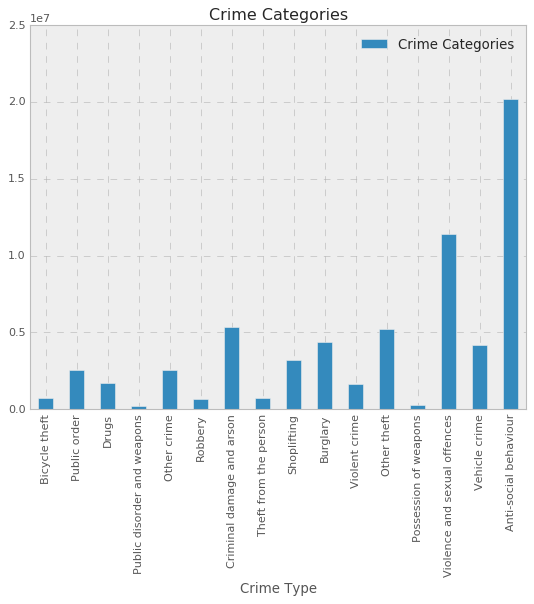

In [171]:
plt.figsize=(20, 6)
df_crime_types.plot(y='count', x='Crime Type', kind = 'bar',\
         subplots=False,
              label='Crime Categories',
              title='Crime Categories')
plt.show()

<h3>Result: </h3>So as from the results overall 16 categories are used 1) Bicycle theft, 2) Public order, 3) Drugs, 4) Public disorder and weapons, 5) Other crime, 6) Robbery, 7) Criminal damage and arson, 8) Theft from the person, 9) Shoplifting, 10) Burglary, 12) Violent crime, 13) Other theft, 14) Possession of weapons, 15) Violence and sexual offences, and 16) Vehicle crime.

<h3>Have the same categories been used consistently?</h3>
For this we gonna filter each category and group them as per time stamp with start data and end data. We will apply aggregate function for filtering the crime category between start and end dates. Further on we will visualize the results

In [19]:
#Getting crime categories with their time frame in which they are recorded from start data to end date
df_consistent_crimes = df_crime_updated.withColumn("Timestamp", to_date(col("Timestamp"),"yyyy-MM")).groupBy("Crime type").agg(min_value("Timestamp").alias("Start date"), max_value("Timestamp").alias("End date")).orderBy("Start date","End date").toPandas()
df_consistent_crimes

,Crime type,Start date,End date
0,Violent crime,2010-12-01,2013-04-01
1,Other crime,2010-12-01,2021-05-01
2,Robbery,2010-12-01,2021-05-01
3,Burglary,2010-12-01,2021-05-01
4,Vehicle crime,2010-12-01,2021-05-01
5,Anti-social behaviour,2010-12-01,2021-05-01
6,Public disorder and weapons,2011-09-01,2013-04-01
7,Drugs,2011-09-01,2021-05-01
8,Criminal damage and arson,2011-09-01,2021-05-01
9,Shoplifting,2011-09-01,2021-05-01


<h4>To check further, I will take of 3 random years 2014, 2017 and 2020 to verify for crime categories consistency</h4>

In [20]:
%%time
df_first = (df_crime_updated
 .select("*")
 .where("Timestamp like '2014%'")
 .groupBy("Timestamp","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
pd_df_first = df_first.groupBy("Crime Type").agg(count("Timestamp").alias("Total")).orderBy("Total", ascending=False).toPandas()
pd_df_first

CPU times: user 52.3 ms, sys: 32.7 ms, total: 85 ms
Wall time: 2min 41s


,Crime Type,Total
0,Bicycle theft,12
1,Public order,12
2,Drugs,12
3,Other crime,12
4,Robbery,12
5,Criminal damage and arson,12
6,Theft from the person,12
7,Shoplifting,12
8,Burglary,12
9,Other theft,12


In [21]:
%%time
df_second = (df_crime_updated
 .select("*")
 .where("Timestamp like '2017%'")
 .groupBy("Timestamp","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
pd_df_second = df_second.groupBy("Crime Type").agg(count("Timestamp").alias("Total")).orderBy("Total", ascending=False).toPandas()
pd_df_second

CPU times: user 61.5 ms, sys: 22.9 ms, total: 84.4 ms
Wall time: 2min 39s


,Crime Type,Total
0,Bicycle theft,12
1,Public order,12
2,Drugs,12
3,Other crime,12
4,Robbery,12
5,Criminal damage and arson,12
6,Theft from the person,12
7,Shoplifting,12
8,Burglary,12
9,Other theft,12


In [22]:
%%time
df_third = (df_crime_updated
 .select("*")
 .where("Timestamp like '2020%'")
 .groupBy("Timestamp","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
pd_df_third = df_third.groupBy("Crime Type").agg(count("Timestamp").alias("Total")).orderBy("Total", ascending=False).toPandas()
pd_df_third

CPU times: user 46 ms, sys: 24.3 ms, total: 70.3 ms
Wall time: 2min 20s


,Crime Type,Total
0,Bicycle theft,12
1,Public order,12
2,Drugs,12
3,Other crime,12
4,Robbery,12
5,Criminal damage and arson,12
6,Theft from the person,12
7,Shoplifting,12
8,Burglary,12
9,Other theft,12


<h4>Furtherbelow plotted a graph based on timestamp</h4>

In [23]:
#Recording timestamps in the form of array for yearly histogram as below below
recorded_timestamps = [x["Timestamp"] for x in df_crime_updated.select('Timestamp').distinct().collect()]
timestamp_yearly_histogram = {}
for timestamp in recorded_timestamps:
  if int(timestamp.split('-')[0]) in timestamp_yearly_histogram:
    timestamp_yearly_histogram[int(timestamp.split('-')[0])] += 1
  else:
    timestamp_yearly_histogram[int(timestamp.split('-')[0])]  = 1
print(timestamp_yearly_histogram)

{2020: 12, 2013: 12, 2019: 12, 2018: 12, 2017: 12, 2021: 5, 2016: 12, 2011: 12, 2015: 12, 2012: 12, 2014: 12, 2010: 1}


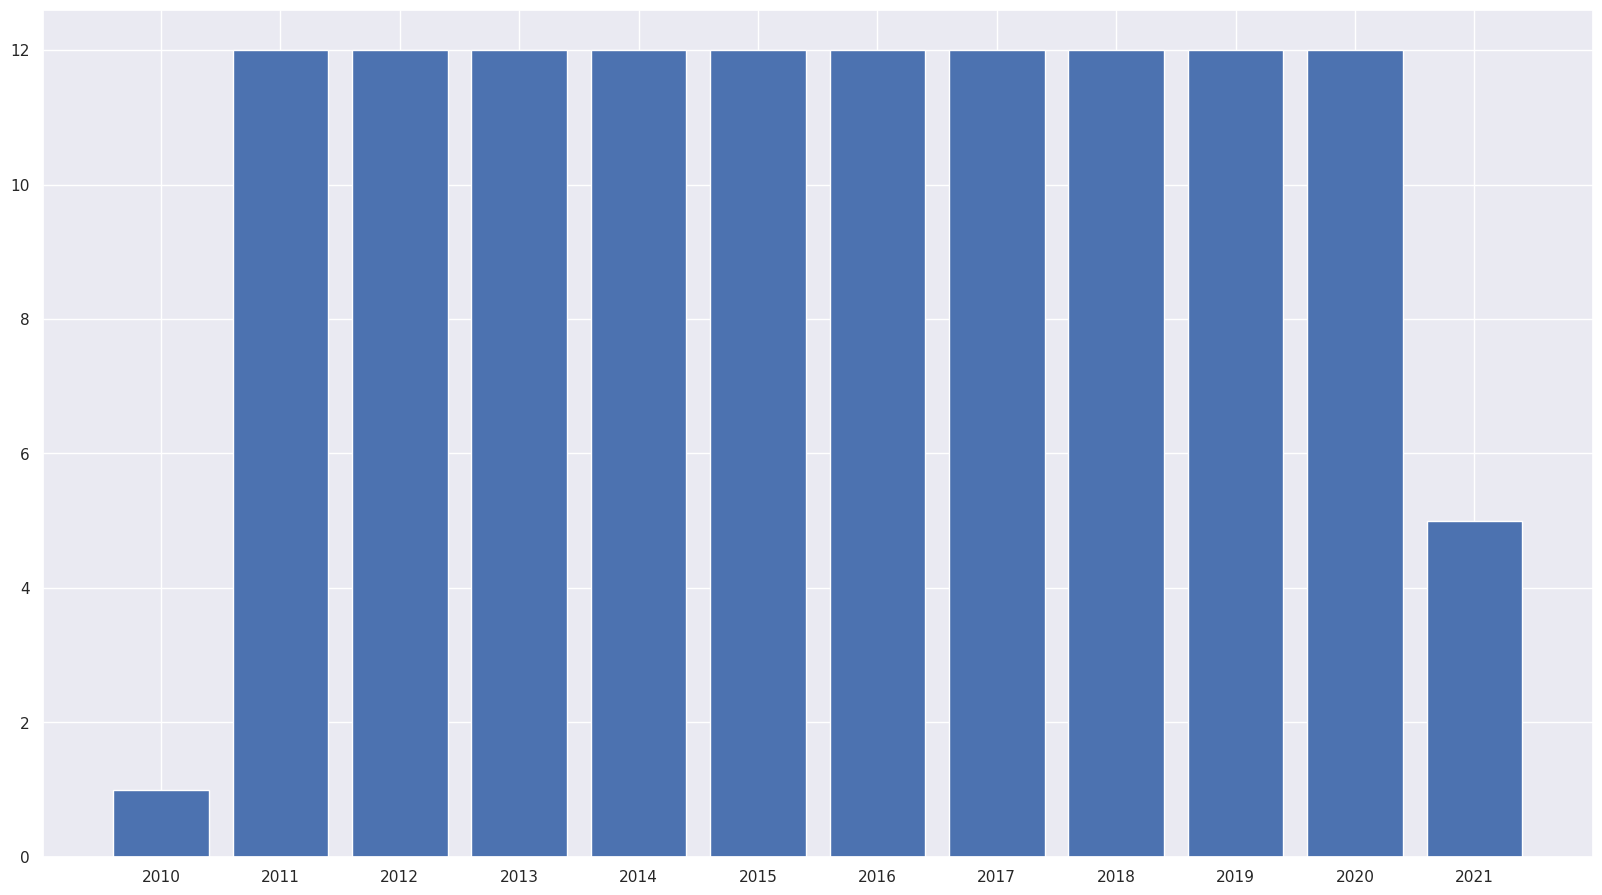

In [25]:
timestamp_yearly_histogram = collections.OrderedDict(sorted(timestamp_yearly_histogram.items()))
plt.bar(range(len(timestamp_yearly_histogram)), list(timestamp_yearly_histogram.values()), align='center')
plt.xticks(range(12), list(timestamp_yearly_histogram.keys()))
plt.show()

In [162]:
crime_count_per_month = {}
crime_type_time = df_crime_updated.groupBy("Crime type", "Timestamp").count().toPandas()
for crime in crime_type_time["Crime type"].unique():
  crime_count_per_month[crime] = {}
  for timestamp in crime_type_time["Timestamp"].unique():
    try:
      crime_count_per_month[crime][timestamp] = int(crime_type_time[(crime_type_time['Crime type'] == crime) & (crime_type_time['Timestamp'] == timestamp)])
    except TypeError:
      crime_count_per_month[crime][timestamp] = float("NaN")
type_month_df = pd.DataFrame(crime_count_per_month).sort_index()
type_month_df


,Anti-social behaviour,Robbery,Other crime,Theft from the person,Shoplifting,Criminal damage and arson,Vehicle crime,Violence and sexual offences,Violent crime,Public order,Burglary,Possession of weapons,Other theft,Drugs,Bicycle theft,Public disorder and weapons
2010-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>Result: </h3> <p>It is clear from the results that most of the categories are used throughout the year a part from violent crime, public disorders and weapons, as those were not recorded after 2013</p>

<h3>Are levels of violent crime constant, increasing, or decreasing</h3>
<p>The first step is to find the violent crimes from our updated dataset and that will be filtered on basis of crime type if it equals to Violence and sexual offences. It is not taking violent crimes in this category as they were not recorded after the year 2013.</p>

In [40]:
df_violent_crimes = df_joined_datasets.select('Reported by', to_date(col("Timestamp"),"yyyy-MM").alias("Date"),'Location', 'Latitude', 'Longitude','LSOA code','LSOA name','Crime type')\
.where((df_joined_datasets["Crime type"] == 'Violence and sexual offences'))

Here is total violent crimes as recorded from 2010 till 2021 as per latest dataset

In [41]:
df_violent_crimes.count()

10837170

In [42]:
#Displaying top 5 crimes from violent dataset
df_violent_crimes.show(5)

+--------------------+----------+--------------------+---------+---------+---------+--------------------+--------------------+
|         Reported by|      Date|            Location| Latitude|Longitude|LSOA code|           LSOA name|          Crime type|
+--------------------+----------+--------------------+---------+---------+---------+--------------------+--------------------+
|Avon and Somerset...|2013-05-01|On or near St Fra...|51.416137|-2.509126|E01014399|Bath and North Ea...|Violence and sexu...|
|Avon and Somerset...|2013-05-01|On or near Back Lane|51.415233|-2.497799|E01014400|Bath and North Ea...|Violence and sexu...|
|Avon and Somerset...|2013-05-01|On or near Furthe...|51.417373|-2.499922|E01014400|Bath and North Ea...|Violence and sexu...|
|Avon and Somerset...|2013-05-01|On or near St Lad...|51.415902|-2.505227|E01014401|Bath and North Ea...|Violence and sexu...|
|Avon and Somerset...|2013-05-01|On or near Hawtho...|51.412394|-2.501363|E01014403|Bath and North Ea...|Violen

<h4>Violent crimes with Date</h4>
<p>Here I am displaying overall violent crimes on the basis of data and month. For this in my query I have ordered it to attribute Data/Timestamp in my dataset.</p>

In [43]:
#Here the crimes are grouped and order as per date and then data is displayed in form of pandas
df_violent_crimes = df_violent_crimes.groupBy(df_violent_crimes.Date).count().orderBy(df_violent_crimes.Date)
pd_violent_crimes = df_violent_crimes.toPandas()
pd_violent_crimes

,Date,count
0,2013-05-01,53577
1,2013-06-01,54301
2,2013-07-01,61093
3,2013-08-01,57777
4,2013-09-01,53567
...,...,...
92,2021-01-01,136351
93,2021-02-01,130181
94,2021-03-01,160269
95,2021-04-01,147015


<h3>Plotting violent crimes on basis of data and it clear that they show an increasing trend</h3>

In [47]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

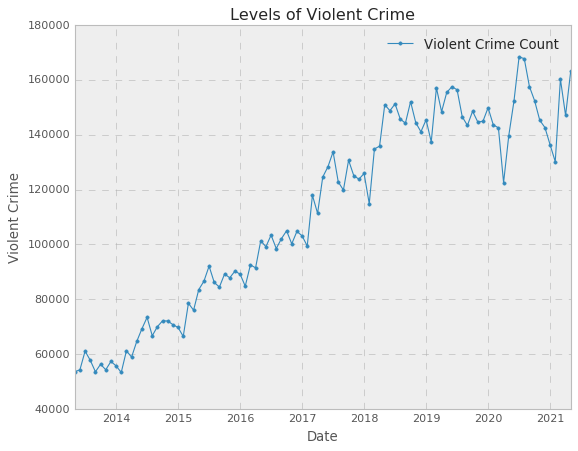

In [160]:
#Computing pandas dataframe to be timeindex for plotting it against crimes commited each year
pd_violent_crimes.Date = pd_violent_crimes.Date.astype('datetime64[ns]')
pd_violent_crimes_upd = pd_violent_crimes.set_index(pd.to_datetime(pd_violent_crimes.Date))
plt.figsize=(20, 6)
pd_violent_crimes_upd.plot(y='count', x='Date',marker='.', linestyle='-', linewidth=1,\
         subplots=False,
              label='Violent Crime Count',
              title='Levels of Violent Crime')
plt.style.use(['bmh'])
plt.ylabel('Violent Crime')
plt.show()

<h3>Result: </h3>As it can been seen violent crimes has an increasing trend if compared as per previous years. And its clear between 2020 and 2021 during the pandemic period it reached its highest limit.

<h4>Visualzing crimes commited each year with their frequency and trend</h4>

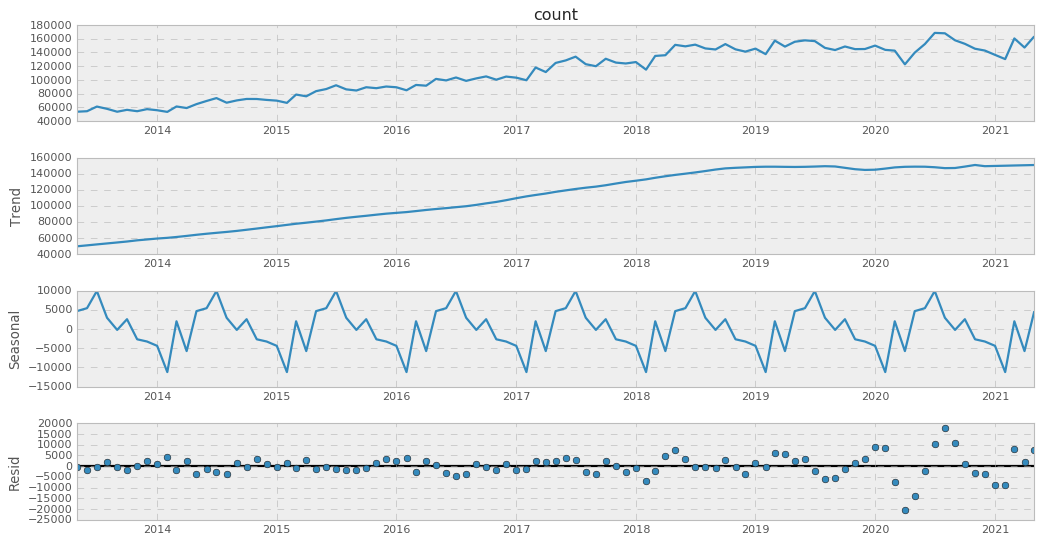

In [133]:
decomposition = sm.tsa.seasonal_decompose(pd_violent_crimes_upd['count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

<h3>Using data prior to the first lockdown predict violent crime levels for April 2020</h3>

In [100]:
#Now getting data before april 2020
crime_before_april_20 = pd_violent_crimes_upd[(pd_violent_crimes_upd.Date.dt.year > 2013) & (pd_violent_crimes_upd.Date.dt.year < 2021)]
crime_before_april_20

,Date,count
Date,,
2014-01-01,2014-01-01,55737
2014-02-01,2014-02-01,53327
2014-03-01,2014-03-01,61217
2014-04-01,2014-04-01,58932
2014-05-01,2014-05-01,64631
...,...,...
2020-08-01,2020-08-01,167746
2020-09-01,2020-09-01,157573
2020-10-01,2020-10-01,152427


<h4>Now further analyzing the trends</h4>

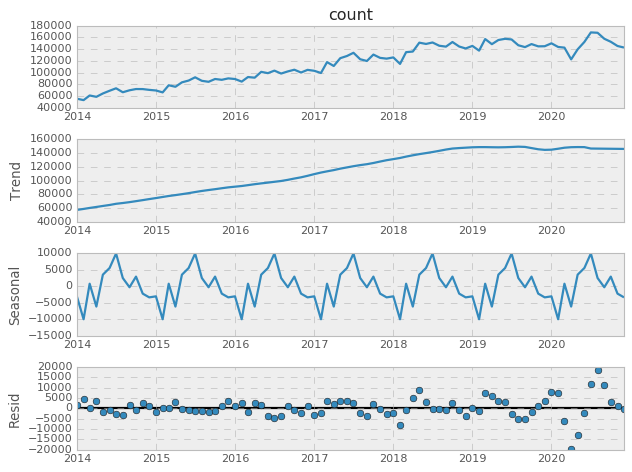

In [134]:
decomposition = sm.tsa.seasonal_decompose(crime_before_april_20['count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

<h3>The Rolling statistics test gives the visual representation of the dataset.</h3>

<p>It can seen below from plot the graph of rolling mean and rolling standard deviation is not constant, this shows that our first dataset is not stationary<p/>

In [83]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

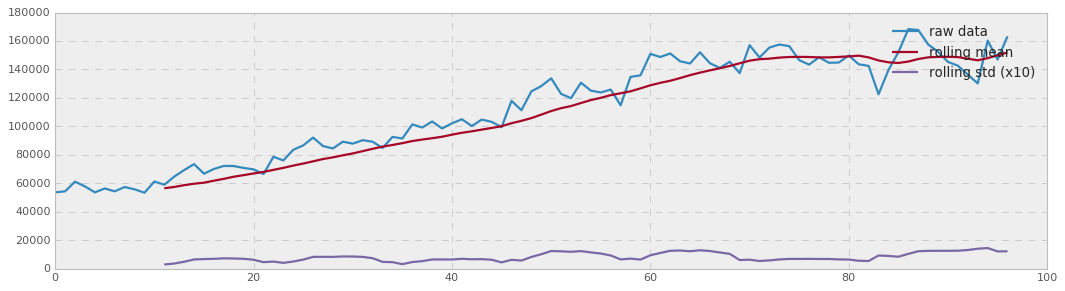

In [135]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(pd_violent_crimes['count'],'raw data')

<h3>Augmented Dickey-Fuller Test</h3>

<p>In this test we take a null hypothesis that the data is non-stationary. It will give some results comprised of test statistics and some other critical values that help to define the stationarity.</p>

In [104]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [40]:
ADF_test(seaborn-deep['count'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.755
P-value = 0.403
Critical values :
	1%: -3.526004646825607 - The data is not stationary with 99% confidence
	5%: -2.9032002348069774 - The data is not stationary with 95% confidence
	10%: -2.5889948363419957 - The data is not stationary with 90% confidence


<h3>Detrending</h3>

In this step we are removing a trend from a time series.We remove that aspect from our data that is causing some kind of distortion. 

<Figure size 640x480 with 0 Axes>

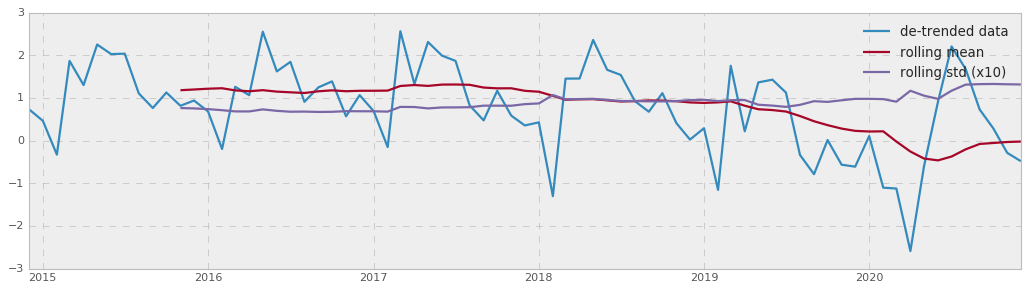

 > Is the de-trended data stationary ?
Test statistic = -0.546
P-value = 0.883
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


In [136]:
# Detrending
y = crime_before_april_20['count']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')


<h3>Differencing</h3>

In this step, we are transforming a time series dataset. It can be used to remove the series dependence on time, so eliminating trend

<Figure size 640x480 with 0 Axes>

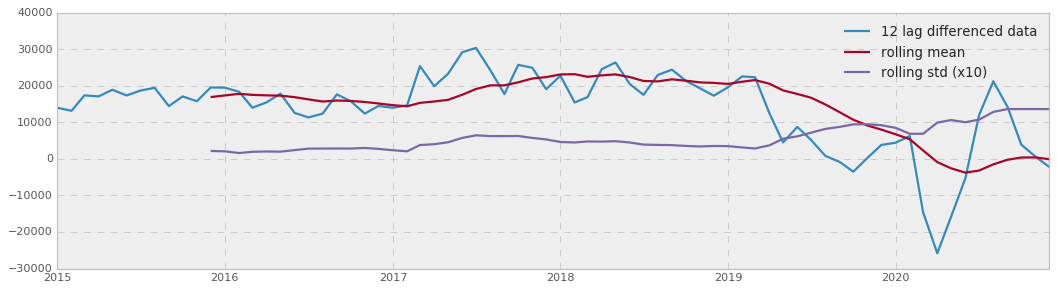

 > Is the 12 lag differenced data stationary ?
Test statistic = -2.093
P-value = 0.247
Critical values :
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence


In [137]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

<Figure size 640x480 with 0 Axes>

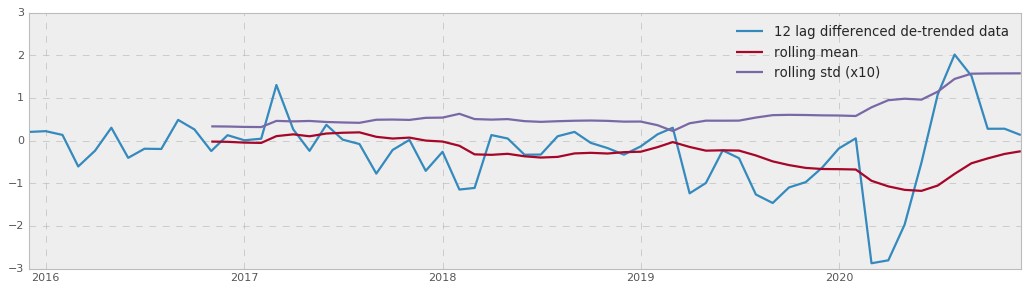

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.432
P-value = 0.000
Critical values :
	1%: -3.5463945337644063 - The data is  stationary with 99% confidence
	5%: -2.911939409384601 - The data is  stationary with 95% confidence
	10%: -2.5936515282964665 - The data is  stationary with 90% confidence


In [138]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

Taking a new pandas dataframe and indexing it as per time

In [141]:
pdf = pd.DataFrame(y_12lag_detrend).reset_index()
pdf.columns = ['Date','Count']
pdf

,Date,Count
0,2014-01-01,NaN
1,2014-02-01,NaN
2,2014-03-01,NaN
3,2014-04-01,NaN
4,2014-05-01,NaN
...,...,...
79,2020-08-01,2.01552597
80,2020-09-01,1.51734568
81,2020-10-01,0.27616628
82,2020-11-01,0.27735271


<h3>Now this is the main step as per comparing predicted crime levels with actuals, and so determine whether significant changes to violent crime occurred. In this step we are splitting our training and testing data.</h3>

In [172]:
y_to_train = y[:'2020-03-01'] # dataset to train
y_to_test = y['2020-04-01': ] # last X months for test  
y_to_val = y_to_test

<h3>ARIMA</h3>

<p>ARIMA, is a statistical analysis model which uses time series data for predicting future trends. In the step below we are generating a list for further processing.</p>

In [144]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The results of our analysis is given below

In [145]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:111.26158054744565
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:111.36719884335326
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:115.43633669934258
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1651.600371198892
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:109.84640281569864
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:107.03118342733254
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:98.82015057058595
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2056.7326785077094
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:101.25085560242391
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:100.25005441783169
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:106.78270957012839
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1646.3238618381915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:99.37338739592562
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:97.62729904526712
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:96.87496781586239
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1699.4295297397784
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:106.66437536088937
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:96.0766725102625

<h3>Now this is the main step in which we are fitting and training the model for further processing. And below plotting our results to ensure results are within normal tolerance</h3>

In [146]:
order = (0, 0, 0) #Using Values from the previous step
seasonal_order = (0, 0, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

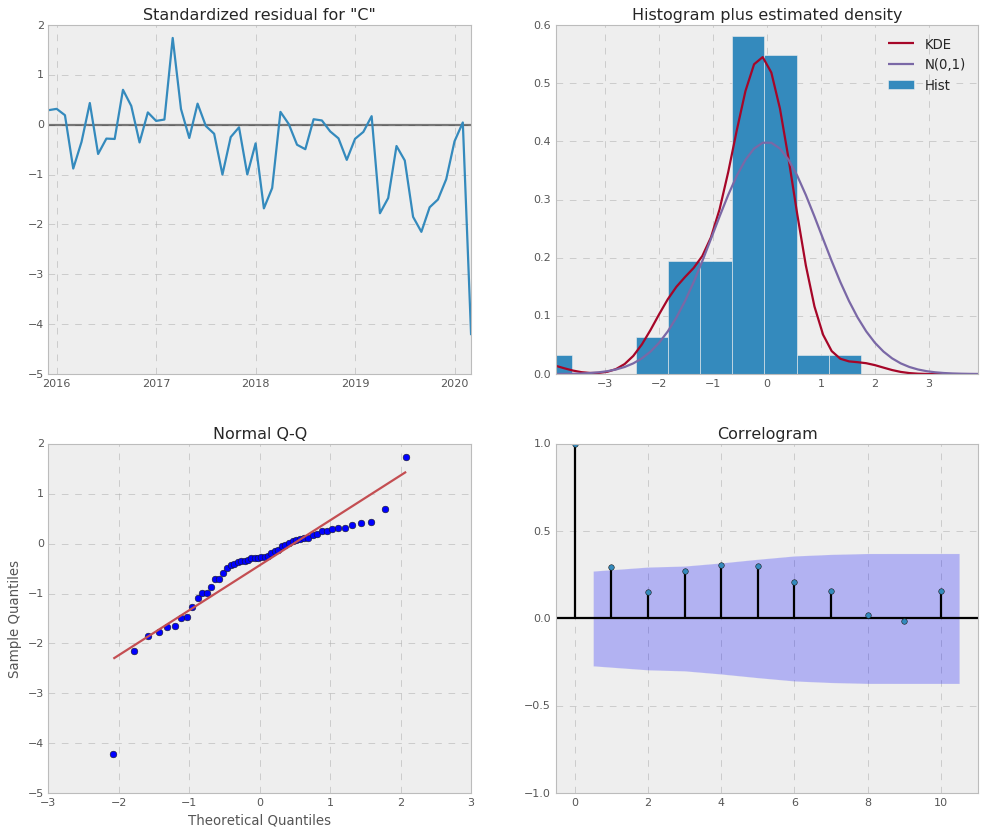

In [147]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

<h4>Now from here we can process or forcast our sets based on the past.</h4>

In [148]:
pred_uc = results.get_forecast(steps=12)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
pred_ci = pred_uc.conf_int()

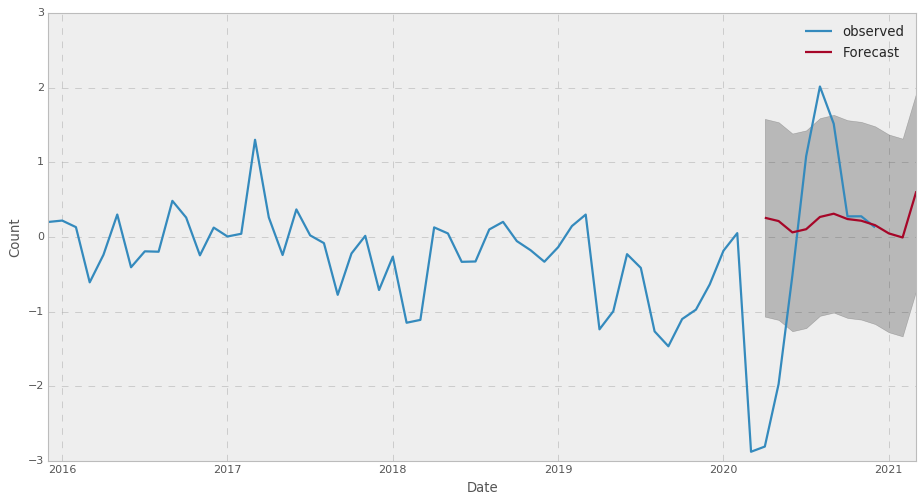

In [149]:
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

<h3>So here generating our predicted and forecasted tables and saving the results.</h3>

In [118]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table.head(20)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-04-01,0.25782380,-1.06648980,1.58213740
1,2020-05-01,0.21347360,-1.11084001,1.53778720
2,2020-06-01,0.06196684,-1.26234676,1.38628045
3,2020-07-01,0.10425019,-1.22006341,1.42856379
4,2020-08-01,0.26833064,-1.05598297,1.59264424
5,2020-09-01,0.31200376,-1.01230984,1.63631736
6,2020-10-01,0.24044845,-1.08386516,1.56476205
7,2020-11-01,0.21775375,-1.10655986,1.54206735
8,2020-12-01,0.15859426,-1.16571922,1.48290773
9,2021-01-01,0.04830348,-1.27600999,1.37261696


In [54]:
y_to_test.head(20)

Date
2020-04-01   -2.80657939
2020-05-01   -1.97003921
2020-06-01   -0.51598812
2020-07-01    1.08155353
2020-08-01    2.01552597
2020-09-01    1.51734568
2020-10-01    0.27616628
2020-11-01    0.27735271
2020-12-01    0.12897441
Name: Count, dtype: float64

Generating CSV of final_table

In [56]:
final_table.to_csv("final_table.csv")

In [57]:
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-04-01,0.25782380,-1.06648980,1.58213740
1,2020-05-01,0.21347360,-1.11084001,1.53778720
2,2020-06-01,0.06196684,-1.26234676,1.38628045
3,2020-07-01,0.10425019,-1.22006341,1.42856379
4,2020-08-01,0.26833064,-1.05598297,1.59264424
5,2020-09-01,0.31200376,-1.01230984,1.63631736
6,2020-10-01,0.24044845,-1.08386516,1.56476205
7,2020-11-01,0.21775375,-1.10655986,1.54206735
8,2020-12-01,0.15859426,-1.16571922,1.48290773
9,2021-01-01,0.04830348,-1.27600999,1.37261696


<h3>The Leicester region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to that region only.</h3>

In [154]:
df_leicester_region = df_joined_datasets.select('Reported by', to_date(col("Timestamp"),"yyyy-MM").alias("Date"),'Location', 'Latitude', 'Longitude','LSOA code','geography','Crime type')\
.where("geography like 'Leicester%'")

In [155]:
df_leicester_region.count()

461485